In [1]:
# Import Common Libraies
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import RobustScaler#, MinMaxScaler, StandardScaler  
from scipy.stats import randint#, uniform 

# For Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials
import optuna 
from optuna.samplers import TPESampler
from sklearn_nature_inspired_algorithms.model_selection import NatureInspiredSearchCV
from niapy.algorithms.basic import CuckooSearch#, ParticleSwarmAlgorithm

# For Machine learning Model
# from sklearn.neighbors import KNeighborsClassifier
from logitboost import LogitBoost

In [2]:
# # For Deep learning Model
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, LeakyReLU, Input, Lambda
# from keras.wrappers.scikit_learn import KerasClassifier
# from keras import backend as K
# import keras 

In [2]:
import os 
os.getcwd()

'c:\\Users\\91629\\OneDrive\\MSC 4TH SEM\\MSC_THESIS_of_Kumarjit_Gupta_(Roll-573)\\Paper_1.1_EEG_Eye_State_Clasification'

In [3]:
os.chdir("..")
# os.chdir("C:/Users/kj/OneDrive/MSC 4TH SEM\MSC_THESIS_of_Kumarjit_Gupta_(Roll-573)")

# Own Library
from Own_Library.ClassifierAnalysis import Splitings, Feature_Selections, Cross_Validations,\
find_reports, best_max_find, best_min_find
from Own_Library.GroupBarPlt_test import groupBarPlot
from Own_Library.Classification_Reports import classification_reports

# Load dataset into the memory
data = pd.read_csv('Dataset\EEG_Eye_State.csv')

print(data.shape)
data.head(3)

(14980, 15)


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,0
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,0
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0


In [5]:
# Select independent features
X = data.iloc[:,:-1]#.values

# Select Dependent features
y = data.iloc[:,-1]#.values

In [6]:
scaler = RobustScaler()
# X = scaler.fit_transform(X)

In [7]:
splits = [0.1, 0.2, 0.25]

# Model 2: Logit Boost

In [8]:
model_2 = LogitBoost()
algoname_2= 'KNN'
dim_2 = False

## 1. All Split Checking
- 1.1. Train 90%, Test 10%
- 1.2. Train 80%, Test 20%
- 1.3. Train 75%, Test 25%

In [9]:
metrics_split = ['F1_Score', 'Markedness', 'Critical_Success_Index']

Technique matrix with total best reports: [0 0 3]
Best test size:  0.25
Spliting Classification Metrics DataFrame:


,Metrics,"Train ratio: 0.9, Test ratio: 0.1","Train ratio: 0.8, Test ratio: 0.2","Train ratio: 0.75, Test ratio: 0.25"
0,F1_Score,0.735265,0.730920,0.739865
1,Markedness,0.479592,0.475596,0.491060
2,Critical_Success_Index,0.582684,0.577015,0.588049


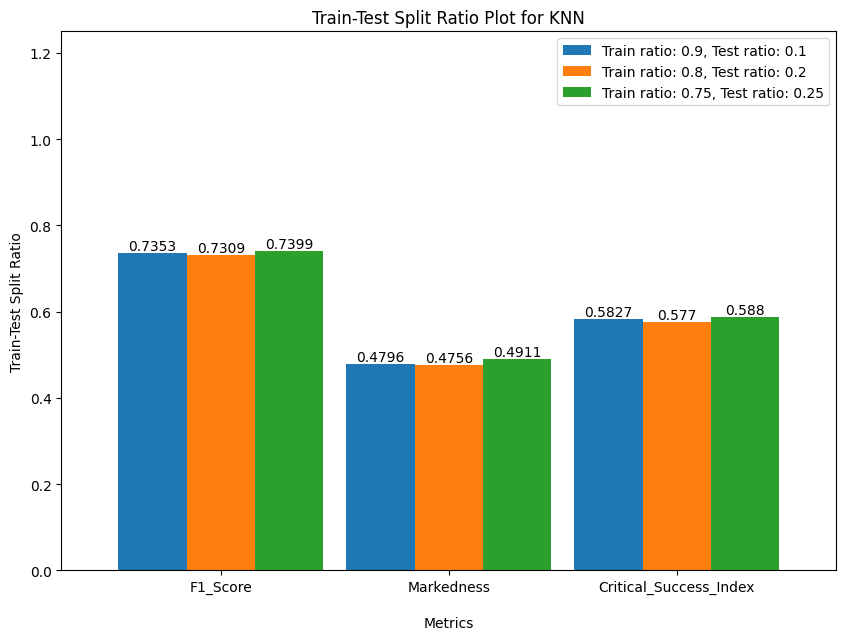

In [10]:
best_split_2, plotdf_split_2 = Splitings(model_2, X, y, splits, metrics_split, algoname_2, dim =dim_2)
print('Spliting Classification Metrics DataFrame:') 
plotdf_split_2

so the best spilit is (90,10) split for better metrics

## 2. ALL Feature section checking
- 2.1. Without Feature Selection 
- 2.2. Pearson Correlation
- 2.3. Mutual info classif
- 2.4. Chi-square

In [11]:
metrics_fs= ['F1_Measure', 'Specificity', 'Negative_Predictive_Value']

Total Selected columns those are correlated above 5% with output column by pearson correlation: 2
Technique matrix with total best reports: [3 0 0 0]
Best Feature Selection Technique: Without
Best Independent vector's Shape by feature Selection: (14980, 14)
Deleted Columns: Not Applicable
Feature Selections Classification Metrics DataFrame:


,Metrics,Without,Pearson Correlation,Mutual Info Classif,Chi_sqaure
0,F1_Measure,0.742297,0.548223,0.667947,0.586627
1,Specificity,0.739064,0.540464,0.666440,0.578142
2,Negative_Predictive_Value,0.745530,0.555982,0.669454,0.595113


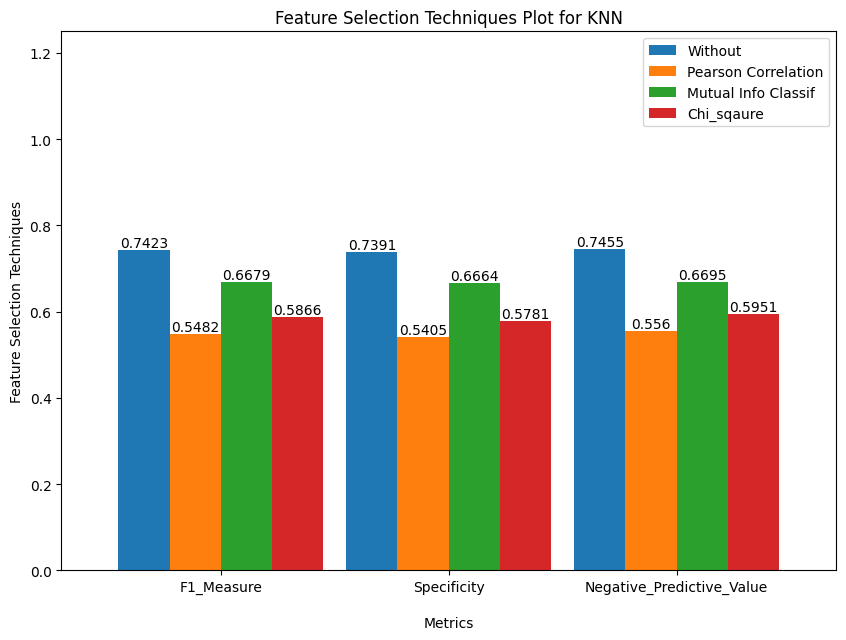

In [12]:
featX_2, plotdf_fs_2, del_cols_2 = Feature_Selections(model_2, data, best_split_2, metrics_fs, algoname_2, dim = dim_2)
print("Best Independent vector's Shape by feature Selection:", featX_2.shape)
print("Deleted Columns:", del_cols_2)
print("Feature Selections Classification Metrics DataFrame:")
plotdf_fs_2

In [13]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(featX_2, y, test_size= best_split_2, random_state=42)
X_train_2 = scaler.fit_transform(X_train_2)
X_test_2 = scaler.transform(X_test_2)
if dim_2:
    X_train_2 = X_train_2.reshape((X_train_2.shape[0], 1, X_train_2.shape[1]))
    X_test_2 = X_test_2.reshape((X_test_2.shape[0], 1, X_test_2.shape[1]))

## 3. All CV CHECKING
- 3.1.  Kfold
- 3.2.  Stratified Kfold
- 3.3.  Shuffle Split

In [14]:
metrics_cv = ['balanced_accuracy', 'accuracy', 'roc_auc']

Technique matrix with total best reports: [3 0 0]
Best CV technique: KFold(n_splits=4, random_state=42, shuffle=True)
Spliting Classification Metrics DataFrame:


,Metrics,KFold,StratifiedKFold,ShuffleSplit
0,mean_balanced_accuracy,0.737862,0.733935,0.732095
1,mean_accuracy,0.747309,0.743125,0.741456
2,mean_roc_auc,0.811009,0.809078,0.807063


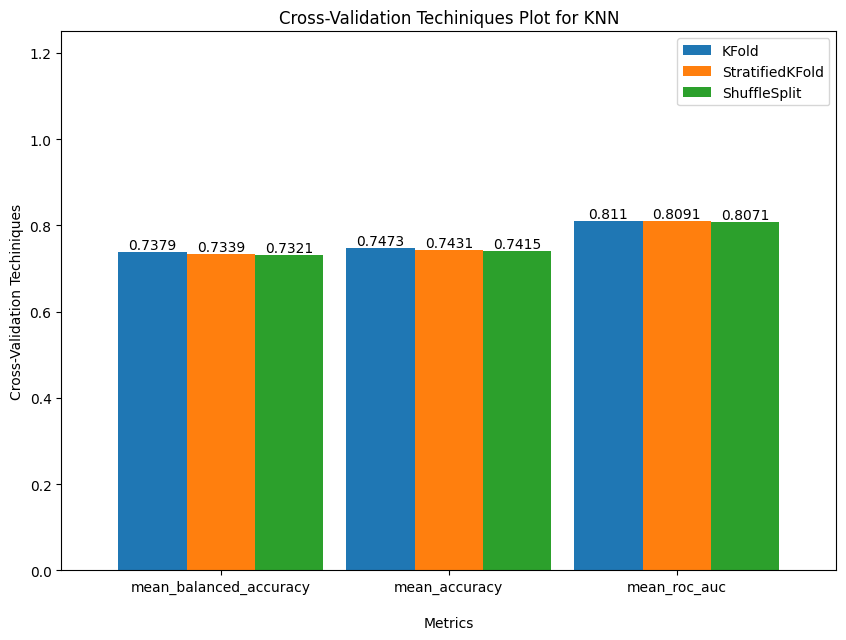

In [15]:
best_cv_2, plotdf_cv_2 = Cross_Validations(model_2, X_train_2, y_train_2, best_split_2, metrics_cv, algoname_2, dim =dim_2)
print('Spliting Classification Metrics DataFrame:') 
plotdf_cv_2

## 4. ALL Hyperparameter tuning checking
- 4.1. Randomized Search CV (Normal Optimization)
- 4.2. HyperOpt (Bayesian Optimization)
- 4.3. Optuna (Asynchronous Distributed Optimization)
- 4.4. Cuckoo Search (NIOA) 

In [16]:
hyp_tunes = ['RandomizedSearchCV', 'Hyperopt', 'Optuna', 'Cuckoo Search']
metrics_hyp = ['Precision', 'Recall', 'Kappa']

In [17]:
m_2 = [0 for _ in range(len(hyp_tunes))]
dict_2= {'Metrics': metrics_hyp}

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

### 4.1. Using Randomized Search CV

In [19]:
# Hyperparameters
param_grid_2 = {'n_estimators':randint(50, 500), #[10,50,100], 
               'base_estimator': [DecisionTreeRegressor(max_depth=10), LinearRegression()]
               }

# Random search for best hyperparameters
search_2 = RandomizedSearchCV(model_2,
                         param_grid_2,
                         cv= best_cv_2,
                         random_state=42, 
                         n_jobs=-1
                        )

search_2.fit(X_train_2, y_train_2)
# Best parameters and best_score
search_2.best_params_, search_2.best_score_

({'base_estimator': DecisionTreeRegressor(max_depth=10), 'n_estimators': 70},
 0.941165910550033)

In [20]:
# pd.DataFrame(search_2.cv_results_)

In [21]:
# Retrain with best model
best_random_search_2 = search_2.best_estimator_

### 4.2. Using HyperOpt

In [24]:
# Define parameter space
space_2 = {'n_estimators': hp.randint('n_estimators', 50, 500), #[10,50,100], 
           'base_estimator':hp.choice('base_estimator', [DecisionTreeRegressor(max_depth=10), LinearRegression()])
            }

def hyperparameter_tuning(params):
    clf = LogitBoost(**params)#, n_jobs=-1)
    acc = cross_val_score(clf, X_train_2, y_train_2, cv= best_cv_2).mean()
    return {"loss": -acc, "model": clf, "status": STATUS_OK}

# Fine tune the model
trials1 = Trials()
best_2 = fmin(
    fn=hyperparameter_tuning,
    space = space_2, 
    algo=tpe.suggest, 
    max_evals=10, 
    trials=trials1, 
)
# best.best_params_
print("Best params: {}".format(best_2))

100%|██████████| 10/10 [01:52<00:00, 11.25s/trial, best loss: -0.7787284068100195]
Best params: {'n_estimators': 449}


In [25]:
# Retrain with best model
best_hyperopt_2= trials1.results[np.argmin([r['loss'] for r in trials1.results])]['model']

### 4.3. Using Optuna

In [27]:
# Define the search space and the objecive function
def objective(trial):
    params = {'n_estimators': trial.suggest_int('n_estimators', 50, 500, 1), #[10,50,100], 
              # 'base_estimator':trial.suggest_categorical('base_estimator', [DecisionTreeRegressor(max_depth=10), LinearRegression()])
            }
    clf = LogitBoost(**params)#, n_jobs=-1)
    score = cross_val_score(clf, X_train_2, y_train_2, scoring="accuracy", cv= best_cv_2).mean()
    return score

# create a study object and pass the objective function to method optimize()
study_2 = optuna.create_study(study_name=f"{algoname_2}_optimization",
                            direction="maximize",
                            sampler=TPESampler())

study_2.optimize(objective, n_trials=10, n_jobs=-1)
# print best parameters 
study_2.best_params, study_2.best_value

[I 2023-05-01 23:56:37,221] A new study created in memory with name: KNN_optimization
[I 2023-05-01 23:56:42,513] Trial 0 finished with value: 0.7514029804991891 and parameters: {'n_estimators': 67}. Best is trial 0 with value: 0.7514029804991891.
[I 2023-05-01 23:56:48,807] Trial 2 finished with value: 0.7665340293054783 and parameters: {'n_estimators': 132}. Best is trial 2 with value: 0.7665340293054783.
[I 2023-05-01 23:56:55,968] Trial 3 finished with value: 0.7679582454747104 and parameters: {'n_estimators': 170}. Best is trial 3 with value: 0.7679582454747104.
[I 2023-05-01 23:56:58,001] Trial 1 finished with value: 0.7786392803858984 and parameters: {'n_estimators': 418}. Best is trial 1 with value: 0.7786392803858984.
[I 2023-05-01 23:57:01,211] Trial 4 finished with value: 0.7671571852886379 and parameters: {'n_estimators': 123}. Best is trial 1 with value: 0.7786392803858984.
[I 2023-05-01 23:57:07,235] Trial 6 finished with value: 0.7677801827966477 and parameters: {'n_esti

({'n_estimators': 362}, 0.7787282483348699)

In [ ]:
# Plot optimization history of all trials in a study.
optuna.visualization.plot_optimization_history(study_2)

In [ ]:
# Retrain with best model
best_optuna_2 = LogitBoost(**study_2.best_params)

### Using Cuckoo Search

In [ ]:
params_2 = {'n_estimators':randint(50, 500), #[10,50,100], 
             'base_estimator': [DecisionTreeRegressor(max_depth=10), LinearRegression()]}

algorithm_2 = CuckooSearch() # when custom algorithm is provided random_state is ignored
algorithm_2.set_parameters(NP=50, Ts=5, Mr=0.25)

nia_search_2 = NatureInspiredSearchCV(
    model_2,
    params_2,
    algorithm=algorithm_2,
    scoring= 'accuracy',
    n_jobs=-1,    
    cv= best_cv_2,
    verbose=0,
    random_state=42,
    return_train_score=False
)

nia_search_2.fit(X_train_2, y_train_2)

# Best Params and score
nia_search_2.best_params_, nia_search_2.best_score_

Fitting KFold(n_splits=10, random_state=42, shuffle=True) folds for some of the 27 candidates, which might total in 270 fits
Optimization finished, 27 candidates were fitted (totalling 270 fits)


({'n_neighbors': 3}, 0.9689954972691058)

<Axes: xlabel='generation', ylabel='max score'>

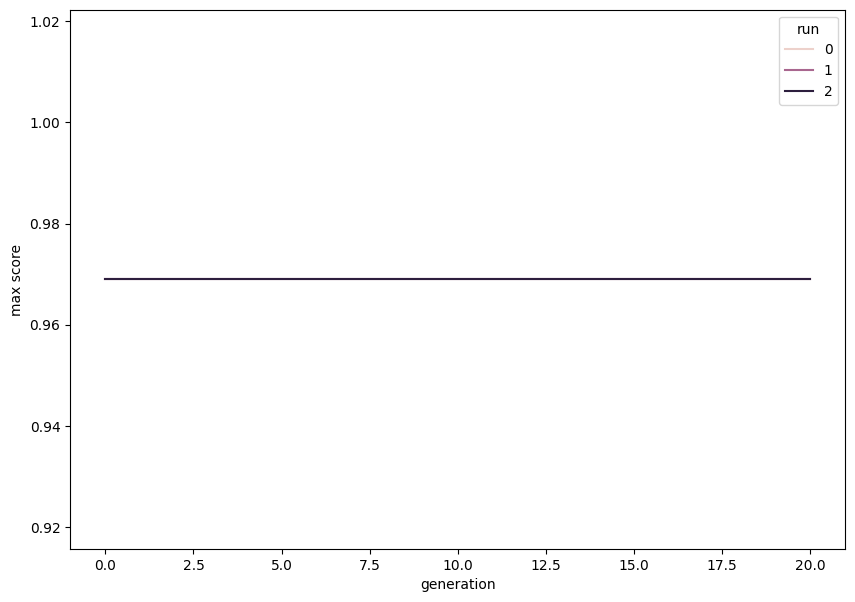

In [ ]:
from sklearn_nature_inspired_algorithms.helpers import score_by_generation_lineplot, score_by_generation_violinplot
score_by_generation_lineplot(nia_search_2, metric='max', ax=None, ylim=None)

<Axes: xlabel='generation', ylabel='score'>

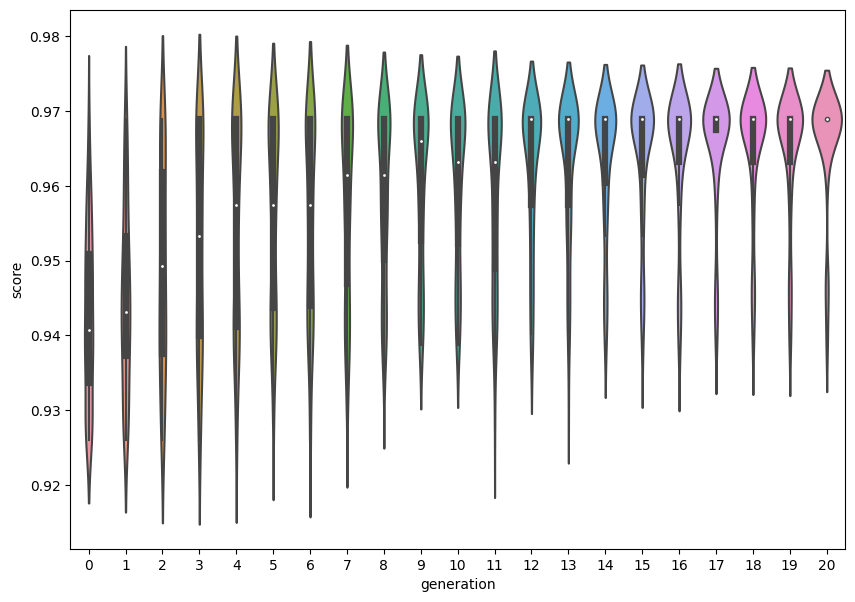

In [ ]:
score_by_generation_violinplot(nia_search_2, run=1, ax=None, ylim=None)

In [ ]:
# pd.DataFrame(nia_search_2.cv_results_)

In [ ]:
# Retrain with best model
best_cuckoo_2 = LogitBoost(**nia_search_2.best_params_)

In [ ]:
all_hyp_2 = [best_random_search_2, best_hyperopt_2, best_optuna_2, best_cuckoo_2]
for i in range(len(hyp_tunes)):
    cldf_2 = find_reports(all_hyp_2[i], X_train_2, X_test_2, y_train_2, y_test_2)
    m_2[i]= pd.to_numeric(cldf_2[metrics_hyp].values[-1])
    dict_2[hyp_tunes[i]] = m_2[i]

In [ ]:
best_hyp_2 = best_max_find(np.array(m_2))
print("Best Hyperparameter tuning Technique:", hyp_tunes[best_hyp_2])

Technique matrix with total best reports: [0 0 3 0]
Best Hyperparameter tuning Technique: Optuna


Hyperparameter Tunings Classification Metrics DataFrame:


,Metrics,RandomizedSearchCV,Hyperopt,Optuna,Cuckoo Search
0,Precision,0.961781,0.973567,0.976609,0.973567
1,Recall,0.961425,0.972559,0.976241,0.972559
2,Kappa,0.923199,0.946071,0.952841,0.946071


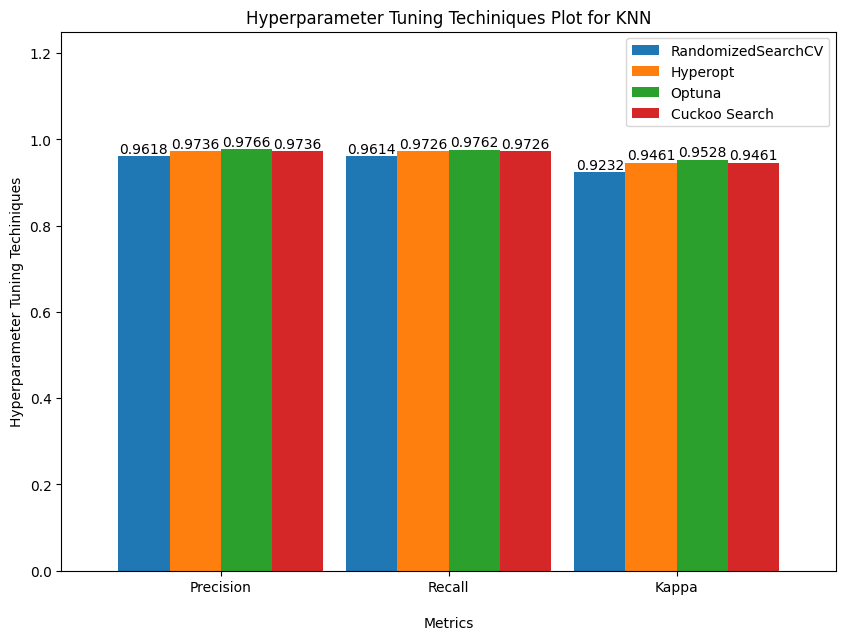

In [ ]:
plotdf_hyp_2 = pd.DataFrame(dict_2)
groupBarPlot(plotname='Hyperparameter Tuning Techiniques', algoname=algoname_2, df=plotdf_hyp_2)
print('Hyperparameter Tunings Classification Metrics DataFrame:') 
plotdf_hyp_2

In [ ]:
y_pred_2= all_hyp_2[best_hyp_2].predict(X_test_2)
best_cldf_2, _ = classification_reports(y_test_2, y_pred_2)
best_cldf_2

,Category,Precision,Recall,F1_Score,F1_Measure,Specificity,Negative_Predictive_Value,False_Positive_Rate,False_Negative_Rate,False_Discovery_Rate,Critical_Success_Index,Fowlkes_Mallows_Index,False_Omission_Rate,Positive_Likelihood_Ratio,Negative_Likelihood_Ratio,Prevalence_Threshold,Diagnostic_Odds_Ratio,Balanced_Accuracy,Mathews_Correlation_Coefficient,Bookmaker_Informedness,Markedness,Accuracy,Kappa,Support
0,0,0.976331,0.972018,0.974170,0.974175,0.980464,0.976886,0.019536,0.027982,0.023669,0.949640,0.974172,0.023114,49.755155,0.028540,0.124166,1743.355263,0.976241,0.952849,0.952482,0.953217,,,679.0
1,1,0.976886,0.980464,0.978672,0.978675,0.972018,0.976331,0.027982,0.019536,0.023114,0.958234,0.978673,0.023669,35.038686,0.020098,0.144522,1743.355263,0.976241,0.952849,0.952482,0.953217,,,819.0
2,Macro_Avg,0.976609,0.976241,0.976421,0.976425,0.976241,0.976609,0.023759,0.023759,0.023391,0.953937,0.976423,0.023391,42.396921,0.024319,0.134344,1743.355263,0.976241,0.952849,0.952482,0.953217,0.976636,0.952841,1498.0
